In [ ]:
# Código completo corregido: carga (si hace falta), features, limpieza, entrenamiento con callbacks, guardado.
from google.colab import files
import io
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler

# ---------- CARGA (si ya subiste el archivo y df está en memoria, comenta la sección de files.upload) ----------
# uploaded = files.upload()
# filename = next(iter(uploaded.keys()))
# df = pd.read_excel(io.BytesIO(uploaded[filename]))

# ---------- Asumir df ya cargado en sesión ----------
print("Dataframe shape:", df.shape)
pd.set_option('display.max_columns', 200)

# ---------- Detectar columnas ----------
cols = df.columns.astype(str).tolist()
date_candidates = [c for c in cols if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
date_col = date_candidates[0] if date_candidates else None

# intentar convertir date_col si existe
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    if df[date_col].isna().all():
        print(f"Advertencia: columna {date_col} no convertible a datetime. Se ignorará como fecha.")
        date_col = None
    else:
        print("Fecha detectada y convertida en:", date_col)
else:
    print("No se detectó columna de fecha.")

# detectar target
target_candidates = [c for c in cols if 'productivity' in c.lower() or 'product' in c.lower() or c.lower()=='prod']
if target_candidates:
    target = target_candidates[0]
    print("Target detectado:", target)
else:
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if 'Total_Items' in numeric_cols and 'Unique_Item_Types' in numeric_cols:
        df['productivity_proxy'] = df['Total_Items'] / (df['Unique_Item_Types'].replace(0, np.nan)).fillna(1)
        target = 'productivity_proxy'
        print("Se creó proxy target 'productivity_proxy'.")
    else:
        raise ValueError("No se encontró target ni columnas para crear proxy.")

group_candidates = [c for c in cols if 'drawer' in c.lower() or 'store' in c.lower() or (c.lower().endswith('_id')) or c.lower()=='id']
group_col = group_candidates[0] if group_candidates else None
if group_col:
    print("Columna de grupo detectada:", group_col)
else:
    print("No se detectó columna de agrupamiento; se usará índice global.")

# ---------- Orden y índice temporal ----------
if group_col and date_col:
    df = df.sort_values([group_col, date_col]).reset_index(drop=True)
elif group_col:
    df = df.sort_values([group_col]).reset_index(drop=True)
elif date_col:
    df = df.sort_values([date_col]).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

if not date_col and group_col:
    df['_seq_in_group'] = df.groupby(group_col).cumcount()
    df['_time_index'] = df['_seq_in_group']
elif date_col:
    df['_time_index'] = (df[date_col].astype('int64') // 10**9)
else:
    df['_time_index'] = df.index

# ---------- Limpiar y preparar target ----------
df = df.copy()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[target])
df['y_raw'] = df[target].astype(float)

# Transformación del target (log1p con manejo de negativos)
min_y = df['y_raw'].min()
if min_y <= -0.5:
    shift_y = abs(min_y) + 1.0
    df['y_shifted'] = df['y_raw'] + shift_y
    df['y'] = np.log1p(df['y_shifted'])
    target_transform = ('log1p_shift', shift_y)
else:
    shift_y = 0.0
    df['y'] = np.log1p(df['y_raw'].clip(lower=0))
    target_transform = ('log1p', 0.0)
print("Target transform:", target_transform)

# ---------- Función para lags y rolling stats ----------
def make_lags_rolls(df, grp, y_col, lags=[1,2,3,7,14,30], rolls=[3,7,14]):
    out = df.copy()
    if grp and grp in out.columns:
        for l in lags:
            out[f'lag_{l}'] = out.groupby(grp)[y_col].shift(l)
        for r in rolls:
            out[f'roll_mean_{r}'] = out.groupby(grp)[y_col].shift(1).rolling(r, min_periods=1).mean().reset_index(0,drop=True)
            out[f'roll_std_{r}']  = out.groupby(grp)[y_col].shift(1).rolling(r, min_periods=1).std().reset_index(0,drop=True).fillna(0)
        out['group_med'] = out.groupby(grp)[y_col].transform('median')
        out['group_mean'] = out.groupby(grp)[y_col].transform('mean')
    else:
        for l in lags:
            out[f'lag_{l}'] = out[y_col].shift(l)
        for r in rolls:
            out[f'roll_mean_{r}'] = out[y_col].shift(1).rolling(r, min_periods=1).mean()
            out[f'roll_std_{r}']  = out[y_col].shift(1).rolling(r, min_periods=1).std().fillna(0)
        out['group_med'] = out[y_col].rolling(30, min_periods=1).median()
        out['group_mean'] = out[y_col].rolling(30, min_periods=1).mean()
    lag_cols = [c for c in out.columns if c.startswith('lag_') or c.startswith('roll_') or c in ['group_med','group_mean']]
    out[lag_cols] = out[lag_cols].bfill().fillna(0)
    return out

df = make_lags_rolls(df, group_col, 'y')

# ---------- Features temporales (seguro) ----------
if date_col and pd.api.types.is_datetime64_any_dtype(df[date_col]):
    df['dow'] = df[date_col].dt.weekday
    df['month'] = df[date_col].dt.month
    df['is_weekend'] = df['dow'].isin([5,6]).astype(int)
else:
    df['dow'] = (df['_time_index'] % 7).astype(int)
    df['month'] = ((df['_time_index'] // 30) % 12).astype(int)
    df['is_weekend'] = (df['dow'].isin([5,6])).astype(int)

# diferencias y ratios seguros
for l in [1,7]:
    if f'lag_{l}' in df.columns:
        df[f'diff_lag{l}'] = df['y'] - df[f'lag_{l}']
        denom = df['y'].replace(0, np.nan)
        df[f'ratio_lag{l}'] = (df[f'lag_{l}'] / denom).fillna(0)

df.fillna(0, inplace=True)

# ---------- Selección de features y limpieza final ----------
feature_cols = [c for c in df.columns if c.startswith('lag_') or c.startswith('roll_') or c in ['group_med','group_mean','dow','month','is_weekend'] or c.startswith('diff_') or c.startswith('ratio_')]
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
const_cols = [c for c in feature_cols if df[c].nunique() <= 1]
if const_cols:
    print("Eliminando constantes:", const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]
if len(feature_cols) == 0:
    raise ValueError("No quedan features útiles. Revisa la creación de lags/rolls y group_col.")
print("Features finales:", feature_cols)

# ---------- Split temporal (últimos 10% como holdout) con salvaguarda ----------
df = df.sort_values('_time_index').reset_index(drop=True)
th = df['_time_index'].quantile(0.9)
train_df = df[df['_time_index'] < th].copy()
holdout_df = df[df['_time_index'] >= th].copy()
min_train_rows = 50
if train_df.shape[0] < min_train_rows and df.shape[0] > min_train_rows:
    cutoff_idx = int(df.shape[0] - max(int(df.shape[0]*0.1), min_train_rows))
    train_df = df.iloc[:cutoff_idx].copy()
    holdout_df = df.iloc[cutoff_idx:].copy()

X_train = train_df[feature_cols].astype(float)
y_train = train_df['y'].astype(float)
X_hold = holdout_df[feature_cols].astype(float)
y_hold = holdout_df['y'].astype(float)
print("Train shape:", X_train.shape, "Holdout shape:", X_hold.shape)

# ---------- Escalado ----------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_hold_scaled = pd.DataFrame(scaler.transform(X_hold), columns=feature_cols, index=X_hold.index)

# ---------- Grid reducido de hiperparámetros ----------
param_grid = [
    {'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 5, 'feature_fraction': 0.8},
    {'learning_rate': 0.03, 'num_leaves': 15, 'min_child_samples': 5, 'feature_fraction': 0.9},
    {'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 3, 'feature_fraction': 0.9},
    {'learning_rate': 0.03, 'num_leaves': 63, 'min_child_samples': 10, 'feature_fraction': 0.7}
]

best_score = 1e9
best_model = None
best_params = None
EPS = 1e-8

# ---------- Entrenamiento con callbacks (early stopping vía callbacks) ----------
for p in param_grid:
    lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
    lgb_valid = lgb.Dataset(X_hold_scaled, label=y_hold, reference=lgb_train)
    params = {
        'objective': 'regression',
        'metric': ['l1','l2'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'learning_rate': p['learning_rate'],
        'num_leaves': p['num_leaves'],
        'min_child_samples': p['min_child_samples'],
        'feature_fraction': p['feature_fraction'],
        'min_split_gain': 0.0,
        'min_data_in_bin': 1
    }
    print("Entrenando con params:", params)
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, first_metric_only=True),
        lgb.log_evaluation(period=100)
    ]
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=2000,
                      valid_sets=[lgb_valid],
                      callbacks=callbacks)

    def invert_pred(y_pred_transformed):
        if target_transform[0] == 'log1p':
            y_pred_raw = np.expm1(y_pred_transformed)
        else:
            y_pred_raw = np.expm1(y_pred_transformed) - target_transform[1]
        return np.clip(y_pred_raw, a_min=0, a_max=None)

    pred_hold_trans = model.predict(X_hold_scaled, num_iteration=getattr(model, 'best_iteration', None))
    pred_hold_raw = invert_pred(pred_hold_trans)
    y_hold_raw = holdout_df['y_raw'].values
    mape_hold = np.mean(np.abs((y_hold_raw - pred_hold_raw) / (np.maximum(np.abs(y_hold_raw), EPS))))
    print("MAPE hold (raw):", mape_hold)
    if mape_hold < best_score:
        best_score = mape_hold
        best_model = model
        best_params = params

print("Mejor MAPE en holdout (raw):", best_score)
print("Mejores params:", best_params)

# ---------- Guardar artefactos ----------
joblib.dump({'model': best_model, 'scaler': scaler, 'feature_cols': feature_cols, 'target_transform': target_transform}, '/content/productivity_lgbm_best.pkl')
print("Guardado en /content/productivity_lgbm_best.pkl")

# ---------- Evaluación final y muestra ----------
pred_hold_trans = best_model.predict(X_hold_scaled, num_iteration=getattr(best_model, 'best_iteration', None))
if target_transform[0] == 'log1p':
    pred_hold_raw = np.expm1(pred_hold_trans)
else:
    pred_hold_raw = np.expm1(pred_hold_trans) - target_transform[1]
pred_hold_raw = np.clip(pred_hold_raw, a_min=0, a_max=None)
y_hold_raw = holdout_df['y_raw'].values
mape_hold = np.mean(np.abs((y_hold_raw - pred_hold_raw) / (np.maximum(np.abs(y_hold_raw), EPS))))
mae_hold = np.mean(np.abs(y_hold_raw - pred_hold_raw))
print(f"Holdout MAPE (final): {mape_hold:.6f}")
print(f"Holdout MAE (final): {mae_hold:.6f}")

comp = holdout_df[[target]].copy()
comp['pred'] = pred_hold_raw
display(comp.head(10))
print("Proceso finalizado.")

Dataframe shape: (100, 32)
Fecha detectada y convertida en: _time_index
Target detectado: productivity_proxy
Columna de grupo detectada: Drawer_ID
Target transform: ('log1p', 0.0)
Eliminando constantes: ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_3', 'roll_std_3', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'dow', 'month', 'is_weekend', 'ratio_lag1', 'ratio_lag7']
Features finales: ['group_med', 'group_mean', 'diff_lag1', 'diff_lag7']
Train shape: (50, 4) Holdout shape: (50, 4)
Entrenando con params: {'objective': 'regression', 'metric': ['l1', 'l2'], 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 5, 'feature_fraction': 0.8, 'min_split_gain': 0.0, 'min_data_in_bin': 1}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.00267006	valid_0's l2: 2.71429e-05
Early stopping, best iteration is:
[146]	valid_0's l1: 0.00255231	valid_0's l2: 2.76375e-05
Eva

,productivity_proxy,pred
50,2.818182,2.833328
51,2.750000,2.750007
52,2.833333,2.833328
53,2.750000,2.750007
54,2.769231,2.769219
55,2.333333,2.333335
56,2.545455,2.538624
57,2.142857,2.142821
58,2.266667,2.249999
59,2.461538,2.428560


Proceso finalizado.


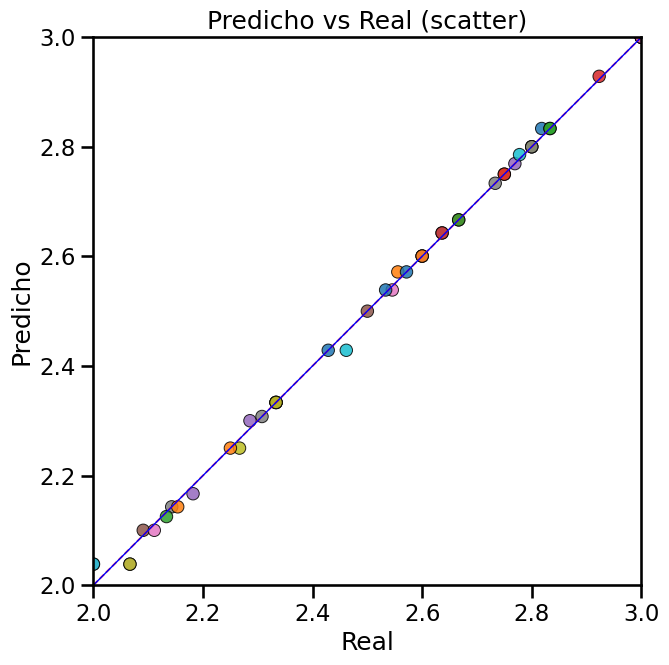

/tmp/ipython-input-2531437665.py:69: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2531437665.py:69: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



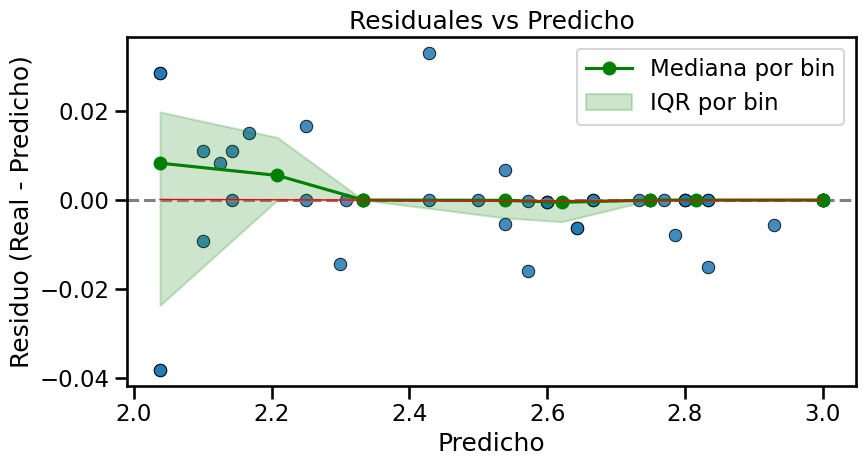

Holdout MAPE: 0.002900
Holdout MAE: 0.006464


,Drawer_ID
50,DRW_051
51,DRW_052
52,DRW_053
53,DRW_054
54,DRW_055
55,DRW_056
56,DRW_057
57,DRW_058
58,DRW_059
59,DRW_060


In [ ]:
# Scatter simples y limpios: Predicho vs Real, Residuales vs Predicho, y Scatter interactivo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotly.express as px
from sklearn.metrics import mean_absolute_error

sns.set_context("talk")
plt.rcParams.update({'figure.max_open_warning': 0})

# cargar artefactos si faltan
if 'best_model' not in globals() or 'scaler' not in globals() or 'feature_cols' not in globals() or 'target_transform' not in globals():
    artifacts = joblib.load('/content/productivity_lgbm_best.pkl')
    best_model = artifacts['model']
    scaler = artifacts['scaler']
    feature_cols = artifacts['feature_cols']
    target_transform = artifacts['target_transform']

# reconstruir holdout_df si no está
if 'holdout_df' not in globals():
    if '_time_index' in df.columns:
        th = df['_time_index'].quantile(0.9)
        holdout_df = df[df['_time_index'] >= th].copy()
    else:
        raise RuntimeError("No existe 'holdout_df' en memoria. Ejecuta la preparación de datos antes.")

# preparar predicciones
X_hold = holdout_df[feature_cols].astype(float).copy()
X_hold_scaled = pd.DataFrame(scaler.transform(X_hold), columns=feature_cols, index=X_hold.index)
pred_trans = best_model.predict(X_hold_scaled, num_iteration=getattr(best_model, 'best_iteration', None))
def invert_pred(y_pred_transformed, target_transform):
    if target_transform[0] == 'log1p':
        y_pred_raw = np.expm1(y_pred_transformed)
    else:
        y_pred_raw = np.expm1(y_pred_transformed) - target_transform[1]
    return np.clip(y_pred_raw, a_min=0, a_max=None)
pred_raw = invert_pred(pred_trans, target_transform)
holdout_df = holdout_df.copy()
holdout_df['y_pred'] = pred_raw
holdout_df['y_true'] = holdout_df['y_raw']
holdout_df['resid'] = holdout_df['y_true'] - holdout_df['y_pred']

# 1) Scatter Predicho vs Real con punto por grupo y LOESS smoothed trend
plt.figure(figsize=(7,7))
sns.scatterplot(data=holdout_df, x='y_true', y='y_pred', hue='Drawer_ID' if 'Drawer_ID' in holdout_df.columns else None,
                palette='tab10', legend=False, s=80, edgecolor='k', alpha=0.85)
minv = min(holdout_df['y_true'].min(), holdout_df['y_pred'].min())
maxv = max(holdout_df['y_true'].max(), holdout_df['y_pred'].max())
plt.plot([minv, maxv], [minv, maxv], color='red', linestyle='--', linewidth=1.2)
sns.regplot(data=holdout_df, x='y_true', y='y_pred', scatter=False, lowess=True, color='blue', line_kws={'lw':1})
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicho vs Real (scatter)')
plt.xlim(minv, maxv)
plt.ylim(minv, maxv)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# 2) Residuales vs Predicho (scatter) con bandas de cuantiles para heterocedasticidad
plt.figure(figsize=(9,5))
sns.scatterplot(data=holdout_df, x='y_pred', y='resid', s=80, edgecolor='k', alpha=0.85)
plt.axhline(0, color='gray', linestyle='--')
# calcular median y percentiles por bins
bins = 8
holdout_df['_bin'] = pd.qcut(holdout_df['y_pred'].rank(method='first'), q=bins, duplicates='drop')
bin_stats = holdout_df.groupby('_bin').apply(lambda z: pd.Series({
    'x': z['y_pred'].median(),
    'med': z['resid'].median(),
    'q1': z['resid'].quantile(0.25),
    'q3': z['resid'].quantile(0.75)
})).reset_index(drop=True)
plt.plot(bin_stats['x'], bin_stats['med'], color='green', marker='o', label='Mediana por bin')
plt.fill_between(bin_stats['x'], bin_stats['q1'], bin_stats['q3'], color='green', alpha=0.2, label='IQR por bin')
sns.regplot(data=holdout_df, x='y_pred', y='resid', scatter=False, lowess=True, color='red', line_kws={'lw':1})
plt.xlabel('Predicho')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Residuales vs Predicho')
plt.legend()
plt.tight_layout()
plt.show()
holdout_df.drop(columns=['_bin'], inplace=True)

# 3) Scatter interactivo con plotly (hover con Drawer_ID, Total_Items si existe)
hover_cols = ['y_true','y_pred','resid']
if 'Drawer_ID' in holdout_df.columns:
    hover_cols.append('Drawer_ID')
if 'Total_Items' in holdout_df.columns:
    hover_cols.append('Total_Items')

fig = px.scatter(holdout_df, x='y_true', y='y_pred',
                 color='Drawer_ID' if 'Drawer_ID' in holdout_df.columns else None,
                 size='Total_Items' if 'Total_Items' in holdout_df.columns else None,
                 hover_data=hover_cols,
                 title='Interactivo: Predicho vs Real')
fig.add_shape(type="line", x0=minv, y0=minv, x1=maxv, y1=maxv, line=dict(color="red", dash="dash"))
fig.update_layout(width=900, height=600)
fig.show()

# Métricas resumen
EPS = 1e-8
mape = np.mean(np.abs((holdout_df['y_true'].values - holdout_df['y_pred'].values) / (np.maximum(np.abs(holdout_df['y_true'].values), EPS))))
mae = mean_absolute_error(holdout_df['y_true'].values, holdout_df['y_pred'].values)
print(f"Holdout MAPE: {mape:.6f}")
print(f"Holdout MAE: {mae:.6f}")

# mostrar primeras filas comparativas
display(holdout_df[['Drawer_ID'] if 'Drawer_ID' in holdout_df.columns else [] + ['y_true','y_pred','resid']].head(20))